In [1]:
from model_training.data import get_ratings_data, stratify_ratings_data

rating_bucket_name = "canihaveatvshowplz-prod-ratingsexport"
rating_file_name = "ratings-1.csv"

ratings_df = get_ratings_data(rating_bucket_name, rating_file_name)
# We should generally stratify our data for training to get a test set, however, I want to set up a different heuristic
# for evaluating performance (user like/user dislike)
# train_set, test_set = stratify_ratings_data(ratings_df)

ratings_df.head()

,UserId,ShowId,IsLiked
0,0021ea5d-bac3-4075-be37-61c51ae9a0d9,f4445a34-46cc-4c01-beea-ba39cc798955,1
1,042e9291-c355-4382-bf55-8b09ce2bfe04,f4445a34-46cc-4c01-beea-ba39cc798955,1
2,04c109dd-c999-4864-b09a-e7c93944ed91,f4445a34-46cc-4c01-beea-ba39cc798955,1
3,04d0a4b8-911a-4943-bd5e-401e32837ca2,f4445a34-46cc-4c01-beea-ba39cc798955,0
4,05f9e444-1fc4-42d9-9314-083626498ad1,f4445a34-46cc-4c01-beea-ba39cc798955,1


In [2]:
print(len(ratings_df))

510727


In [3]:
from model_training.pipelines import get_knn_pipeline
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

pipeline = get_knn_pipeline(label_encoder=label_encoder)

df = pipeline.fit_transform(ratings_df)
transposed_df = df.T

transposed_df.head()

/Users/mav/code/personal/canihaveatvshowplz/model_training/model_training/transformers.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_copy[col].map({"True": True, "False": False}).fillna(X_copy[col])


UserIdEncoded,0,1,2,3,4,5,6,7,8,9,...,304526,304527,304528,304529,304530,304531,304532,304533,304534,304535
ShowIdEncoded,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
from sklearn.neighbors import NearestNeighbors


model = NearestNeighbors(n_neighbors=5, metric="cosine", algorithm="brute")
model.fit(transposed_df)


NearestNeighbors(algorithm='brute', metric='cosine')

In [5]:
import pandas as pd


def predict_nearest_neighbor(show_ids, model=None, df=pd.DataFrame(data={})):
    if model is None:
        raise "Model must be set"
    if (len(df)) == 0:
        return []
    if len(show_ids) == 0:
        return []

    liked_shows_indices = []

    for show_id in show_ids:
        show_index = df.columns.get_loc(show_id)
        liked_shows_indices.append(show_index)

    liked_shows_subset = df[show_ids]
    liked_shows_subset_transposed = liked_shows_subset.T

    distances, indices = model.kneighbors(liked_shows_subset_transposed, n_neighbors=3)

    # Rank based on distance
    similar_shows_indices = indices.flatten().tolist()
    similar_show_ids = df.columns[similar_shows_indices]
    similar_distances = distances.flatten()

    similar_shows_with_distances = dict(zip(similar_show_ids, similar_distances))
    sorted_similar_shows = sorted(
        similar_shows_with_distances.items(), key=lambda x: x[1]
    )

    sorted_show_ids = [show[0] for show in sorted_similar_shows]

    # Filter shows included in provided show_ids
    sorted_show_ids = [x for x in sorted_show_ids if x not in show_ids]

    return sorted_show_ids

In [6]:
show_ids = [
    "21e62709-a428-4e7a-8003-69754848fec7", # The Wire
    "4092f3aa-5f1d-4128-927b-81bb28be9b15", # The Sopranos
]

label_encoder = LabelEncoder()
label_encoder.fit_transform(ratings_df['ShowId'])
encoded_show_ids = label_encoder.transform(show_ids)

recommended_shows = predict_nearest_neighbor(encoded_show_ids, model, transposed_df.T)

decoded_recommended_shows = label_encoder.inverse_transform(recommended_shows)

print(decoded_recommended_shows)

['0cb7c48c-4fcb-462d-87cb-3b43d055a994'
 '38b9e35d-4e0d-4e62-9b0f-d24fe0e6157e']


In [7]:
from model_training.graph import generate_graph

graph = generate_graph(model, df)

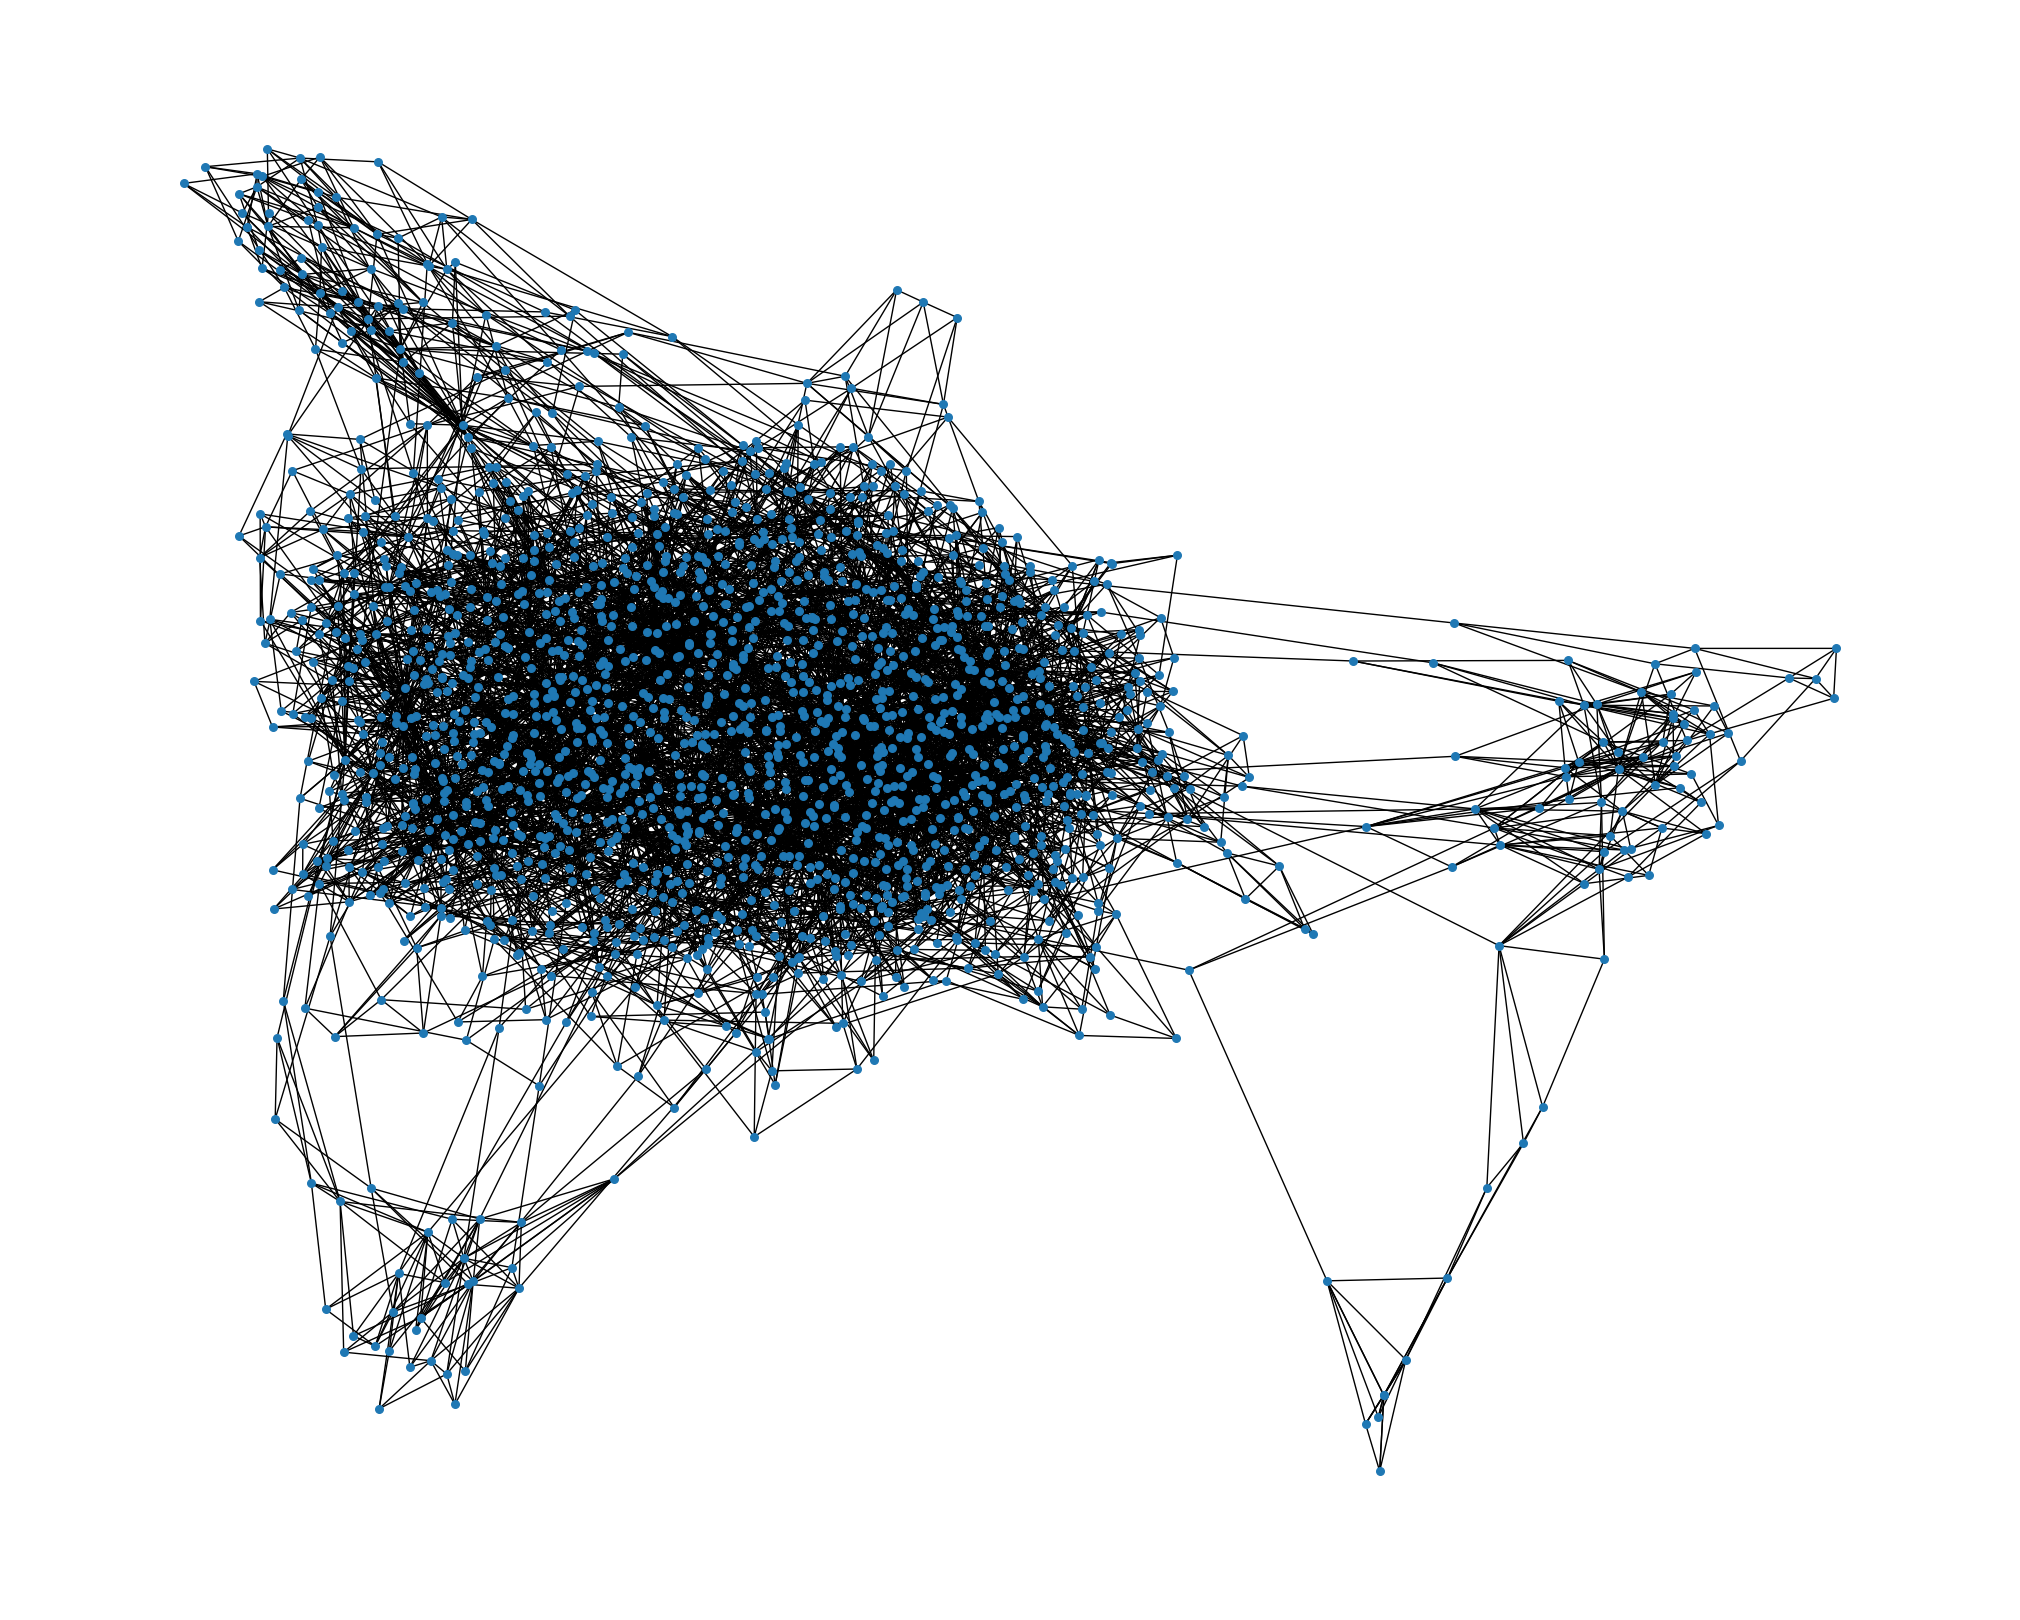

In [8]:
import networkx as nx
from matplotlib import pyplot as plt

plt.figure(figsize=(20, 16))
pos = nx.spring_layout(graph)  # Layout algorithm to position nodes
nx.draw(graph, pos, with_labels=False, node_size=30)
plt.show()

In [20]:
from sklearn.preprocessing import LabelEncoder

def generate_show_recommendations(graph, show_ids, top_n=3):
    similar_shows = {}

    for show_id in show_ids:
        if show_id in graph:
            neighbors = list(graph.neighbors(show_id))

            # Count common neighbors for each neighbor of the input show
            for neighbor in neighbors:
                if neighbor != show_id:
                    if neighbor in similar_shows:
                        similar_shows[neighbor] += 1
                    else:
                        similar_shows[neighbor] = 1

    sorted_shows = sorted(similar_shows.items(), key=lambda x: x[1], reverse=True)

    recommended_shows = [show[0] for show in sorted_shows if show[0] not in show_ids]

    return recommended_shows[:top_n]

show_ids = [
    "21e62709-a428-4e7a-8003-69754848fec7", # The Wire
    "4092f3aa-5f1d-4128-927b-81bb28be9b15", # The Sopranos
]

label_encoder = LabelEncoder()
label_encoder.fit_transform(ratings_df['ShowId'])
encoded_show_ids = label_encoder.transform(show_ids)

recommended_shows = generate_show_recommendations(graph, encoded_show_ids)

decoded_recommended_shows = label_encoder.inverse_transform(recommended_shows)

print(decoded_recommended_shows)

['38b9e35d-4e0d-4e62-9b0f-d24fe0e6157e'
 'dce60409-866a-4a85-adeb-e43b38004b23'
 'a88273a4-fd19-499a-8478-a600fcb6969e']


In [10]:
import pickle

pickle.dump(model, file = open("model.pickle", "wb"))
pickle.dump(graph, file = open("graph.pickle", "wb"))